In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import pickle
from collections import defaultdict

import torch
import gpytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import logomaker
import seaborn as sns
from scipy.stats import norm
from rdkit import Chem
from botorch.models.gpytorch import GPyTorchModel
from botorch.fit import fit_gpytorch_model
from map4 import MAP4Calculator
from MDAnalysis.analysis.rms import rmsd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from mobius import SequenceGA, ScaffoldGA, GA
from mobius import Map4Fingerprint, SequenceDescriptors, DMTSimulation
from mobius import expected_improvement, greedy, probability_of_improvement, TanimotoSimilarityKernel
from mobius import HELMGeneticOperators
from mobius import MHCIPeptideScorer
from mobius import affinity_binding_to_energy, energy_to_affinity_binding, compute_probability_matrix, plot_results
from mobius.helm import build_helm_string, parse_helm
from mobius.gaussian_process import GPModel
from mobius.acquisition_functions import AcqScoring

## Testing training size dataset and energy spanning range

In [3]:
mhci = pd.read_csv('../mhc/binding_data_2013/bdata.20130222.mhci.csv')
print(mhci[mhci['mhc_allele'].str.contains("HLA")]['mhc_allele'].unique().shape)

# We removed those binding affinity values
# A lot of peptides were set with those values. Looks like some default values assigned...
dirty_values = [1, 2, 3, 5000, 10000, 20000, 43424, 50000, 69444.44444, 78125]

# Split dataset in training and testing sets
mhci = mhci[(mhci['mhc_allele'] == 'HLA-A*02:01') &
            (mhci['length'] <= 11) &
            (mhci['length'] >= 9) &
            (~mhci['affinity_binding'].isin(dirty_values))]

print(mhci.shape)

(119,)
(8327, 7)


In [4]:
pssm_files = ['../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-8.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-9.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-10.txt',
              '../mhc/IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-02:01-11.txt']
mps = MHCIPeptideScorer(pssm_files, mhci)

----- Peptide global -----
N peptide: 8327
R2: 0.616
RMSD : 1.180 kcal/mol



In [5]:
map4 = Map4Fingerprint(input_type='helm', dimensions=4096, radius=1)

### Affinity binding values between 500 uM and 1 mM (noise sigma: 1)

Energy bounds: -4.531 / -4.118 kcal/mol


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


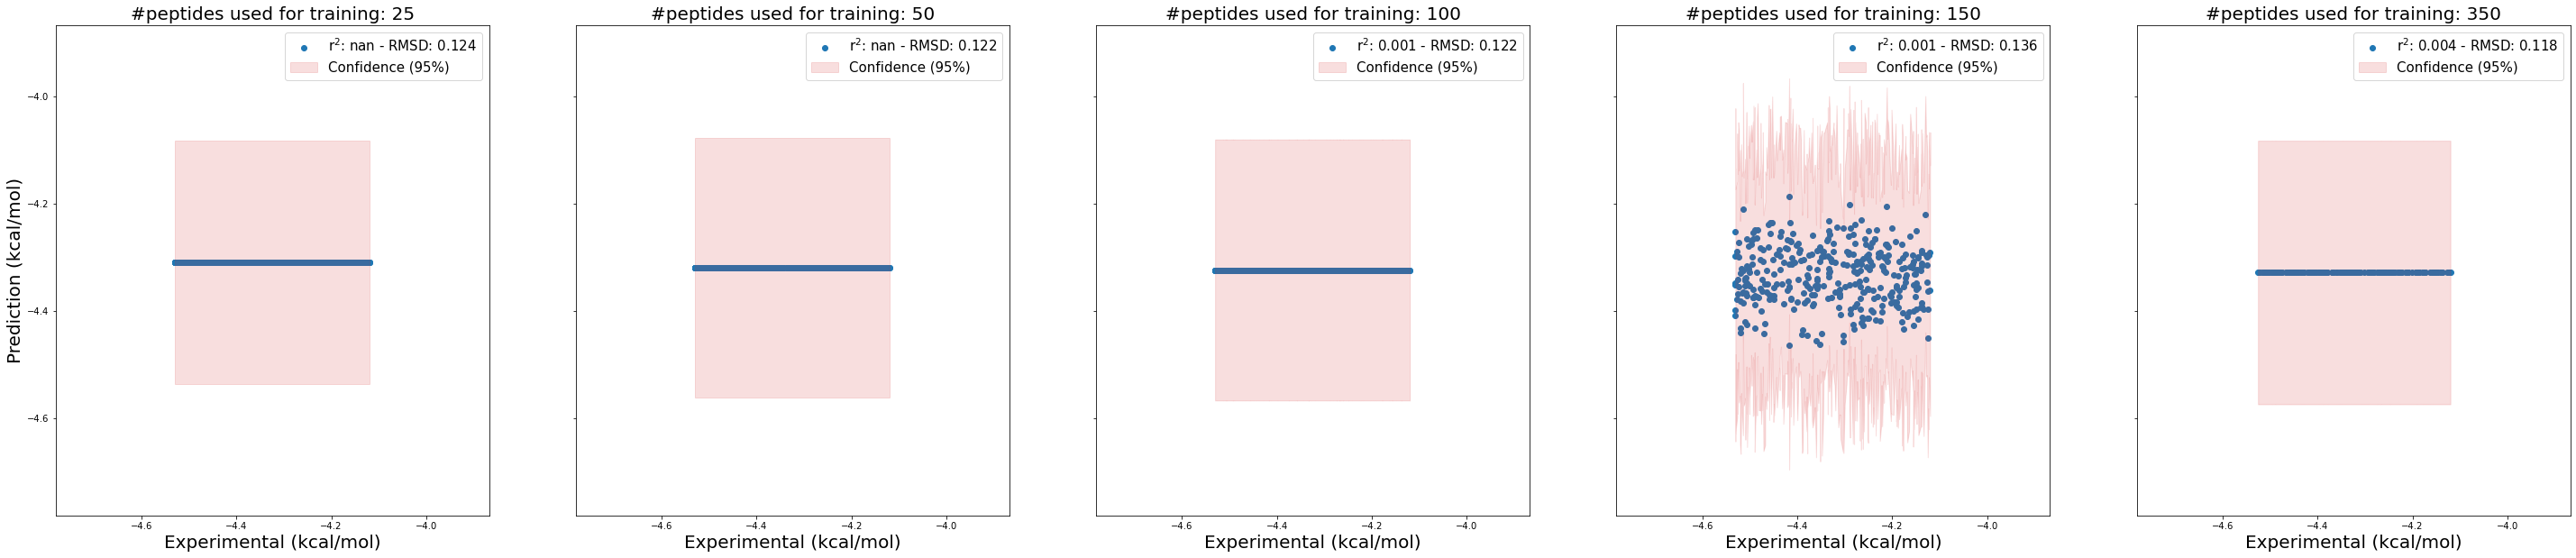

In [20]:
energy_bounds = [affinity_binding_to_energy(500, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):    
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Fit GP model and do prediction
    gp = GPModel(kernel=TanimotoSimilarityKernel())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test)
    
    # Plotting
    ax.scatter(y_test, y_pred, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test, y_pred)[0]**2, rmsd(y_test, y_pred)))
    ax.fill_between(y_test[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (kcal/mol)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (kcal/mol)', fontsize=20)
ax.set_xlim([energy_bounds[0] - 0.25, energy_bounds[1] + 0.25])
ax.set_ylim([energy_bounds[0] - 0.25, energy_bounds[1] + 0.25])

plt.show()

### Affinity binding values between 500 uM and 1 mM (noise sigma: 1e-4)

Energy bounds: -4.531 / -4.118 kcal/mol


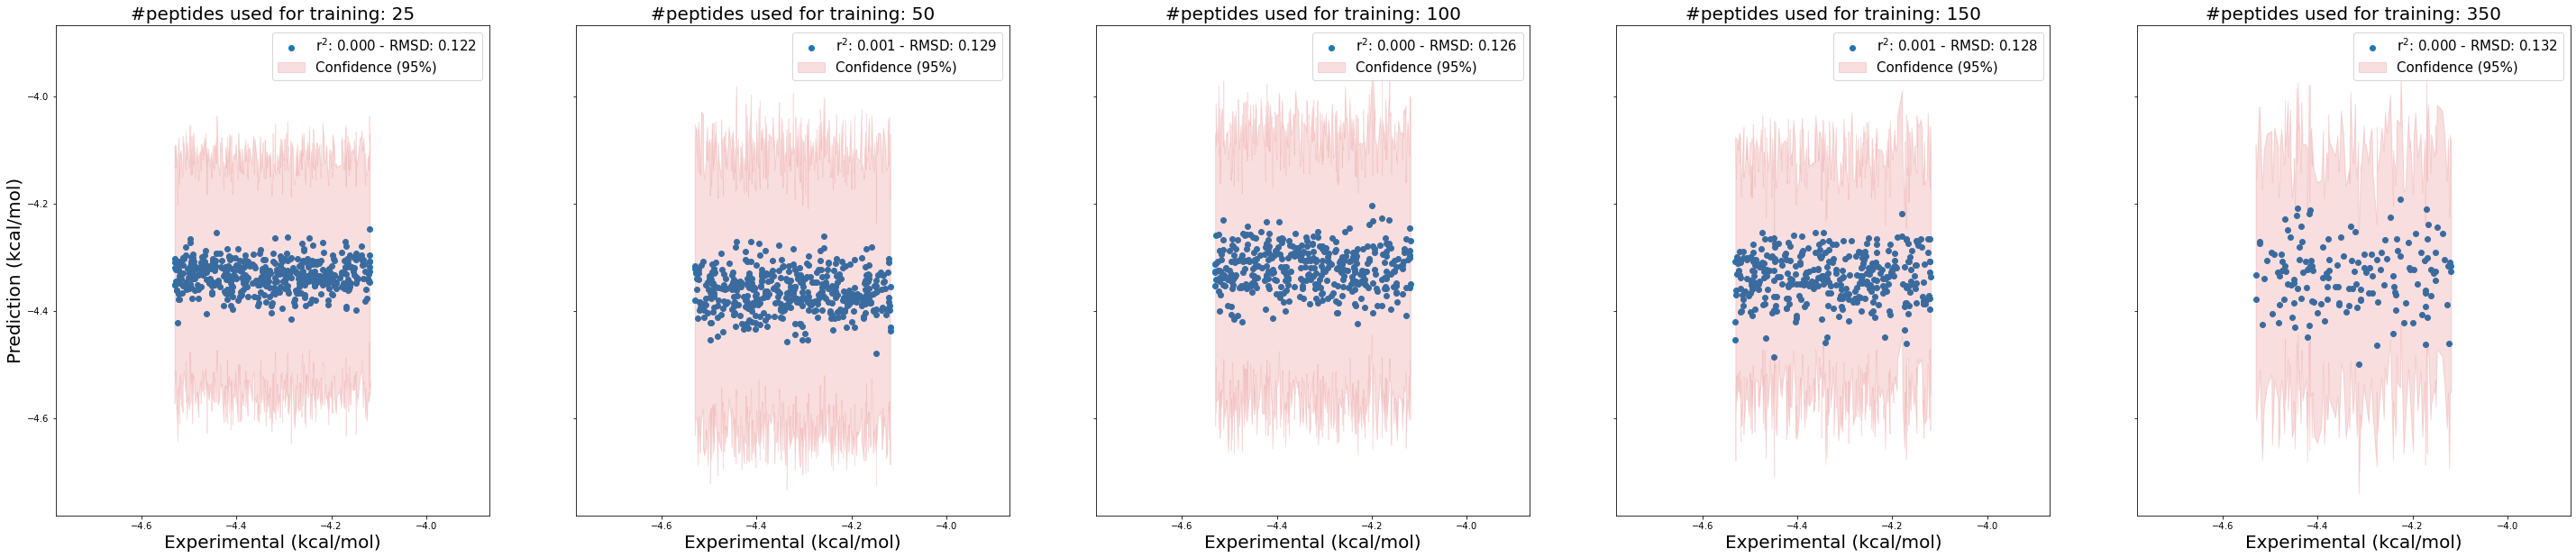

In [22]:
energy_bounds = [affinity_binding_to_energy(500, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):    
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Fit GP model and do prediction
    gp = GPModel(kernel=TanimotoSimilarityKernel(), noise_parameters=(0, 1e-4))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test)
    
    # Plotting
    ax.scatter(y_test, y_pred, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test, y_pred)[0]**2, rmsd(y_test, y_pred)))
    ax.fill_between(y_test[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (kcal/mol)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (kcal/mol)', fontsize=20)
ax.set_xlim([energy_bounds[0] - 0.25, energy_bounds[1] + 0.25])
ax.set_ylim([energy_bounds[0] - 0.25, energy_bounds[1] + 0.25])

plt.show()

### Affinity binding values between 1 uM and 1 mM (noise sigma: 1)

Energy bounds: -8.235 / -4.118 kcal/mol


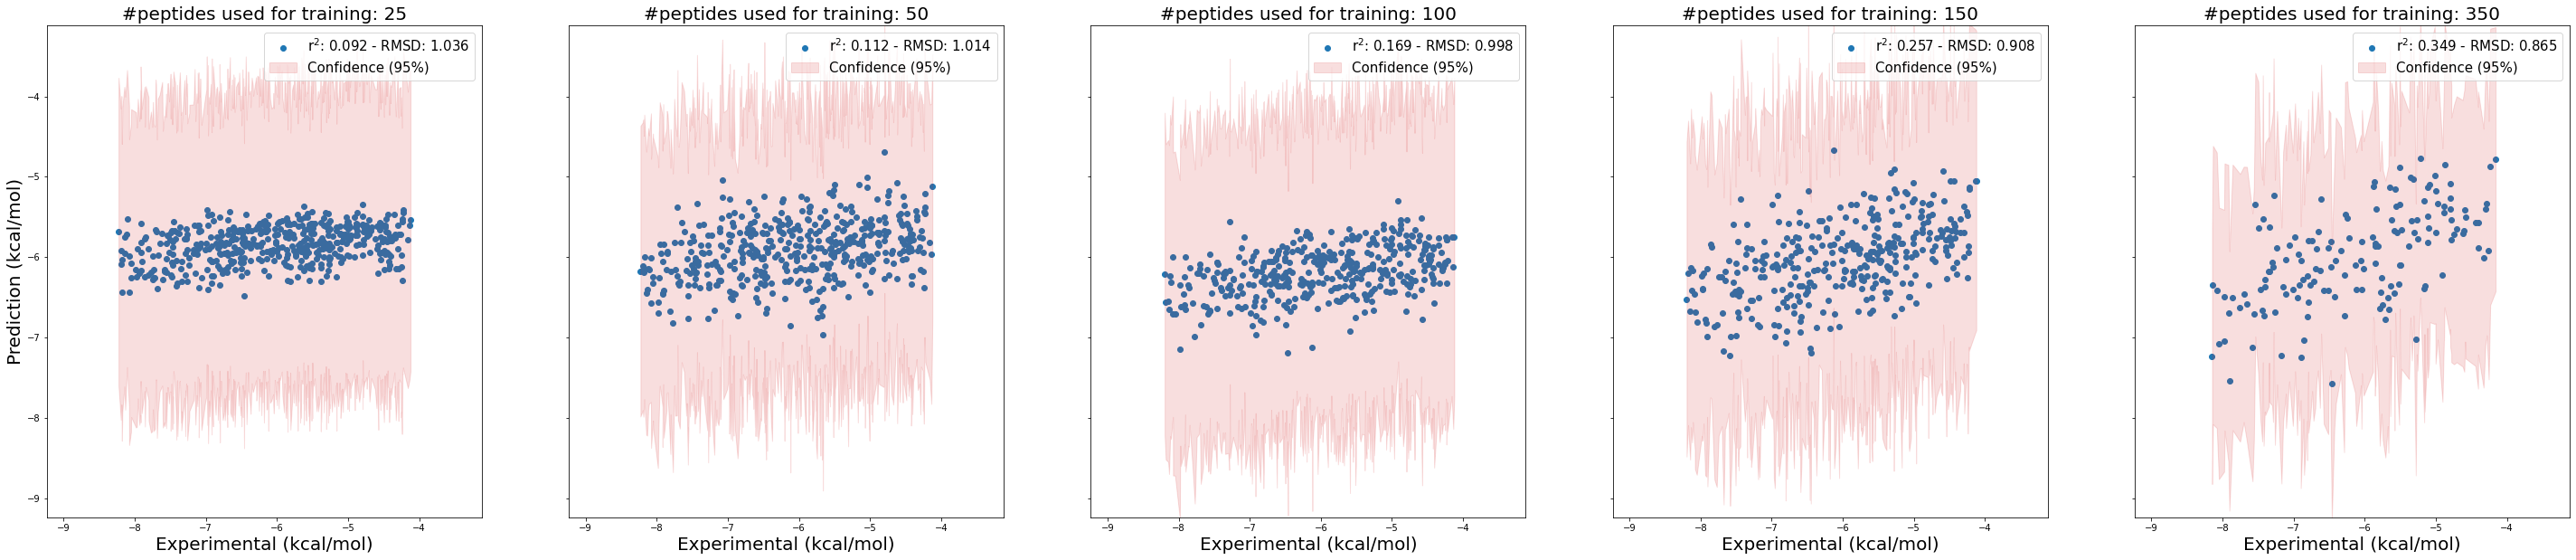

In [25]:
energy_bounds = [affinity_binding_to_energy(1, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Fit GP model and do prediction
    gp = GPModel(kernel=TanimotoSimilarityKernel())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test)
    
    # Plotting
    ax.scatter(y_test, y_pred, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test, y_pred)[0]**2, rmsd(y_test, y_pred)))
    ax.fill_between(y_test[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (kcal/mol)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (kcal/mol)', fontsize=20)
ax.set_xlim([energy_bounds[0] - 1, energy_bounds[1] + 1])
ax.set_ylim([energy_bounds[0] - 1, energy_bounds[1] + 1])

plt.show()

### Affinity binding values between 1 nM and 1 uM (noise sigma: 1)

Energy bounds: -12.353 / -8.235 kcal/mol


/home/eberhardt/Applications/miniconda3/envs/python3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


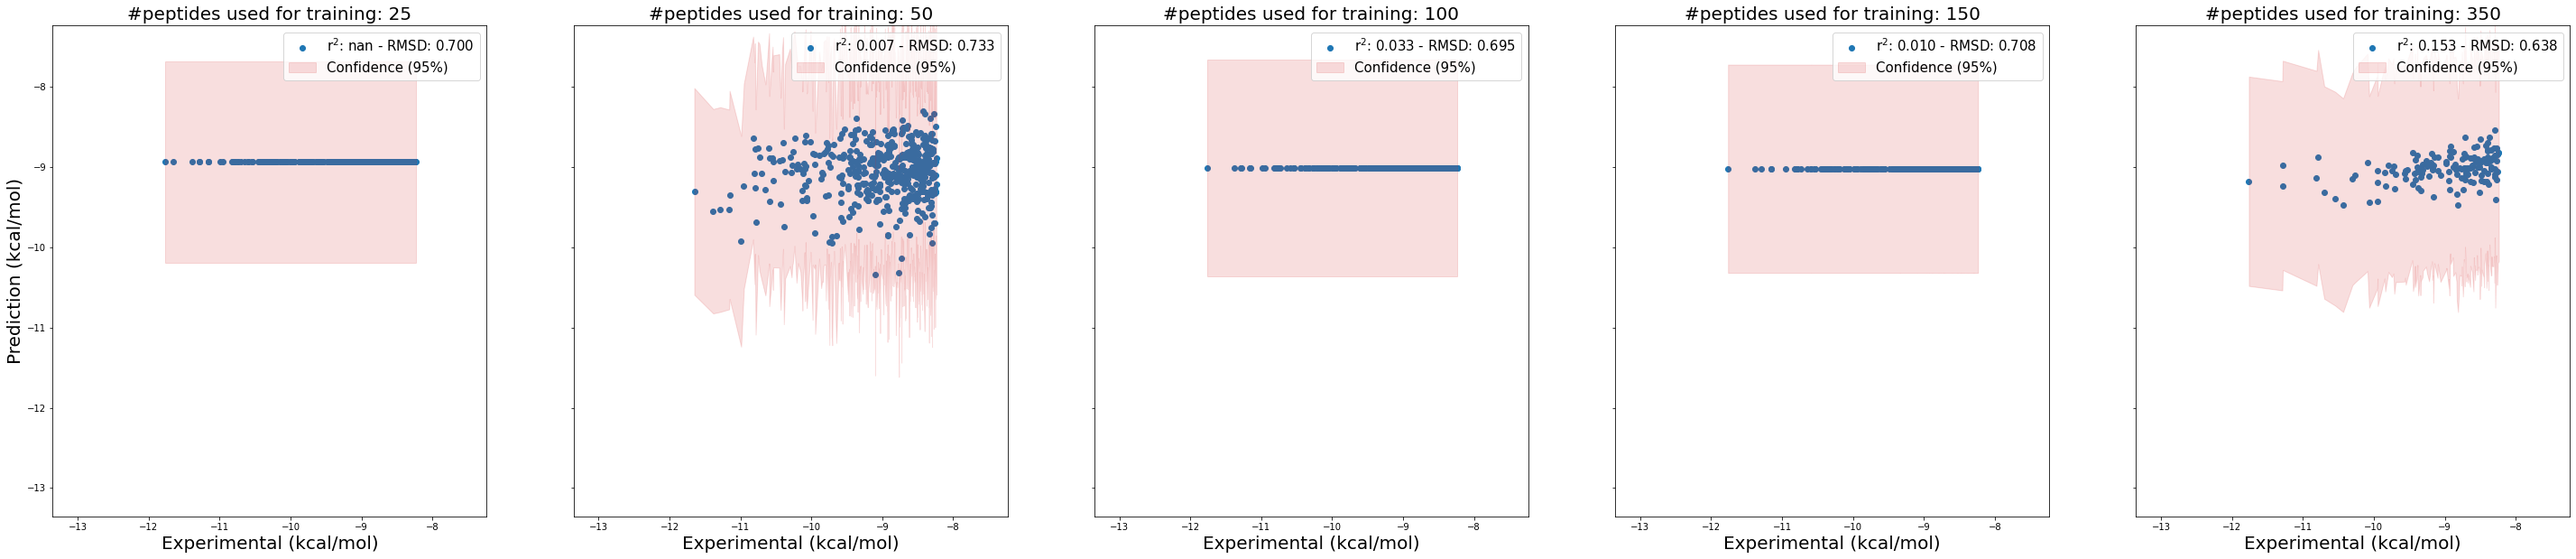

In [26]:
energy_bounds = [affinity_binding_to_energy(1, 'nM'), affinity_binding_to_energy(1, 'uM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Fit GP model and do prediction
    gp = GPModel(kernel=TanimotoSimilarityKernel())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test)
    
    # Plotting
    ax.scatter(y_test, y_pred, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test, y_pred)[0]**2, rmsd(y_test, y_pred)))
    ax.fill_between(y_test[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (kcal/mol)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (kcal/mol)', fontsize=20)
ax.set_xlim([energy_bounds[0] - 1, energy_bounds[1] + 1])
ax.set_ylim([energy_bounds[0] - 1, energy_bounds[1] + 1])

plt.show()

### Affinity binding values between 500 uM and 1 mM (noise sigma: 1, values standardized)

Energy bounds: -4.531 / -4.118 kcal/mol


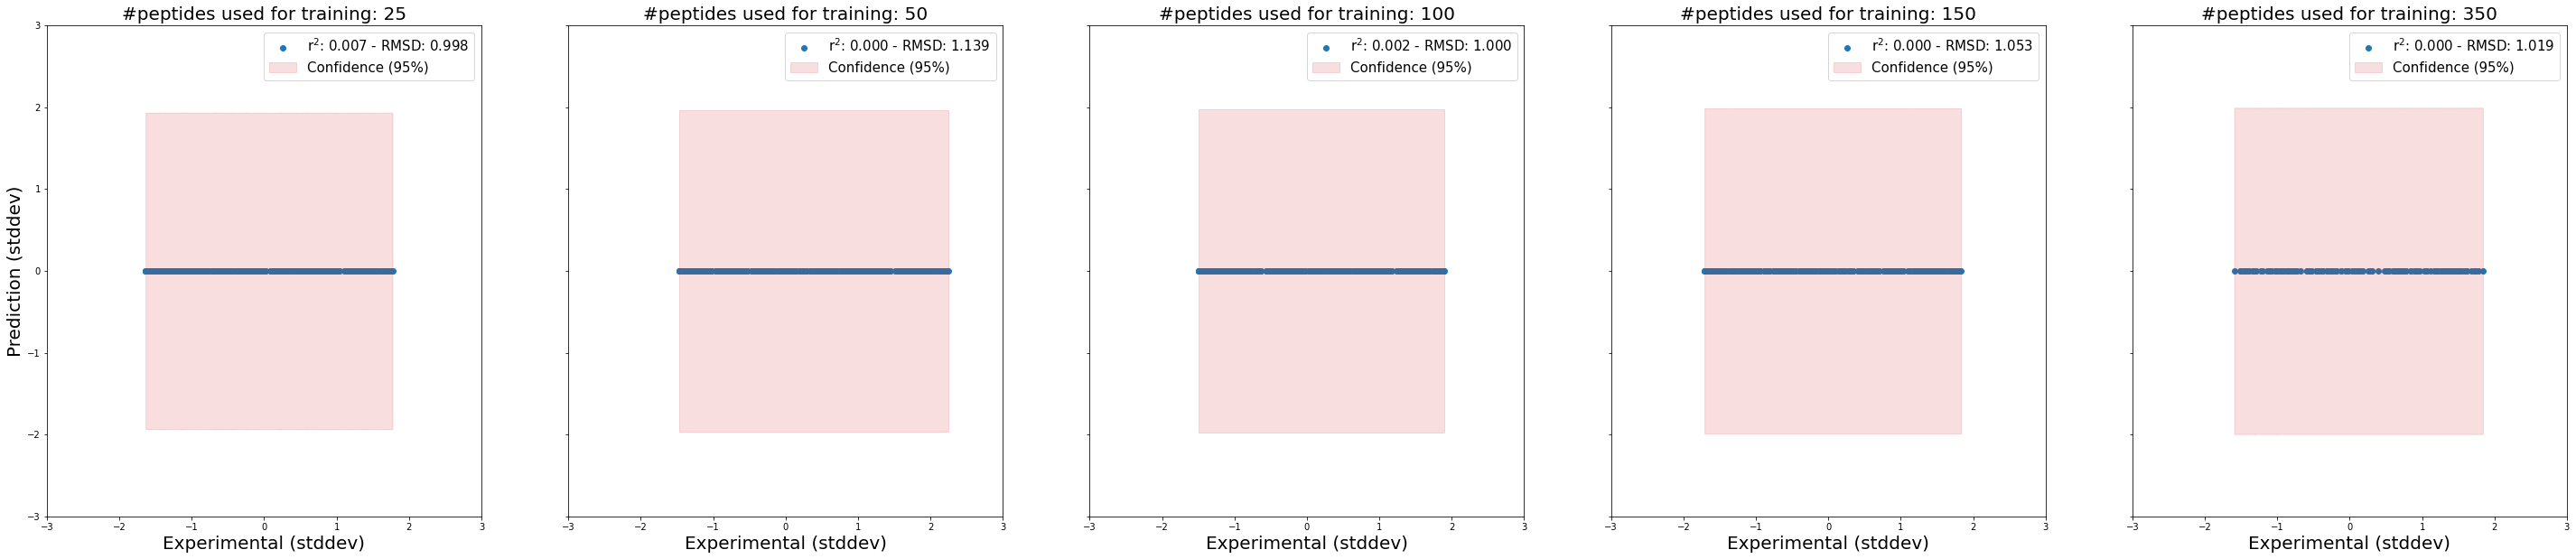

In [45]:
energy_bounds = [affinity_binding_to_energy(500, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = StandardScaler()
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=StandardScaler())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

plt.show()

### Affinity binding values between 500 uM and 1 mM (noise sigma: 1, values normalized)

Energy bounds: -4.531 / -4.118 kcal/mol


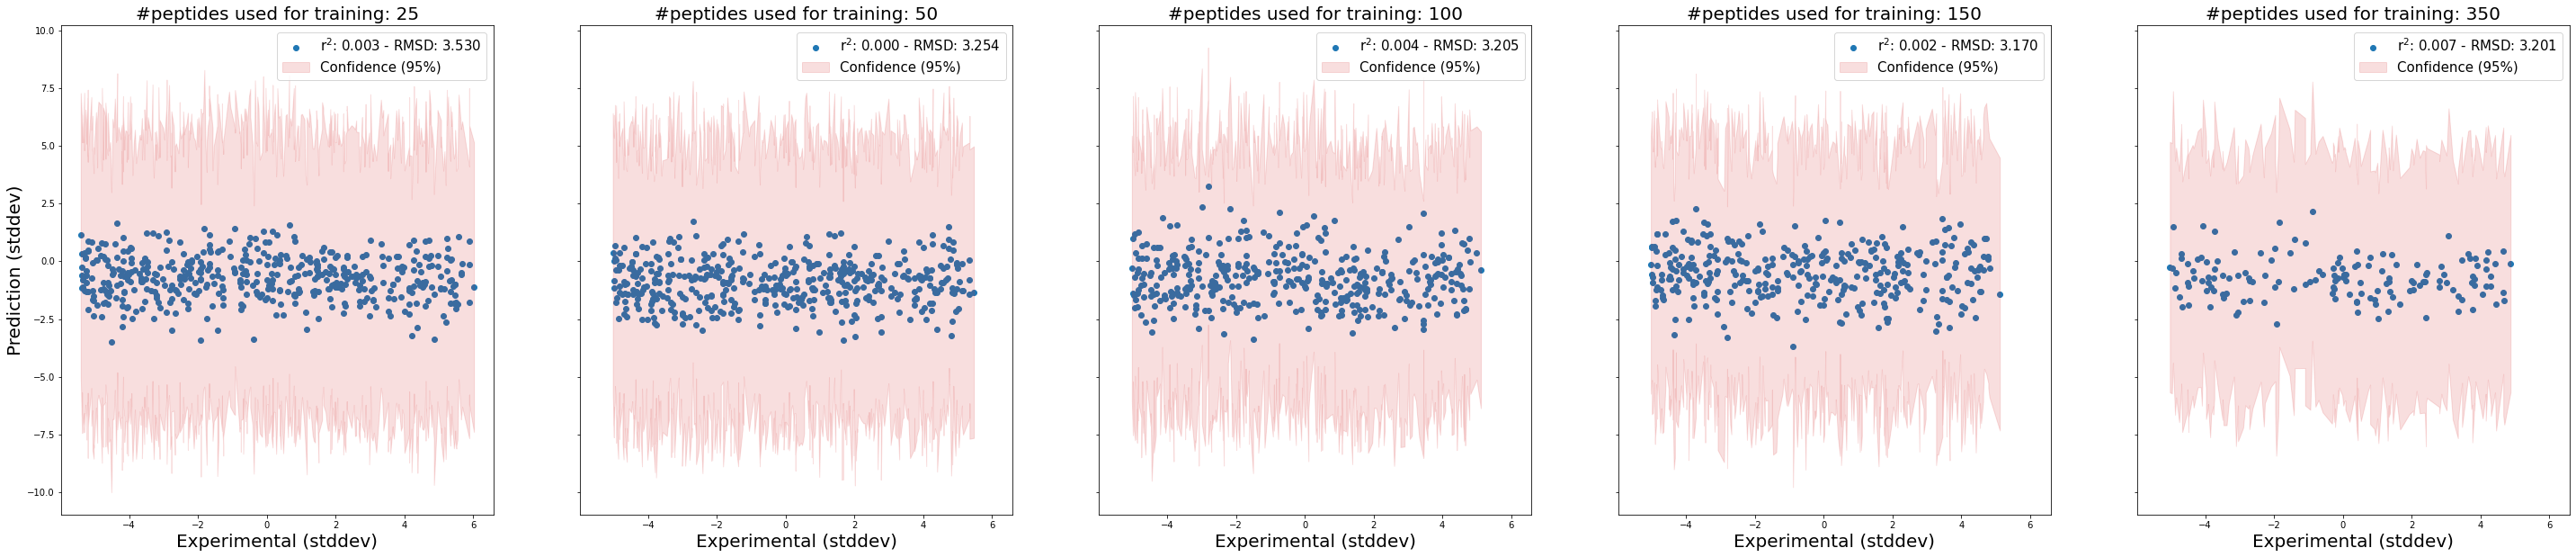

In [46]:
energy_bounds = [affinity_binding_to_energy(500, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = MinMaxScaler((-5, 5))
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=MinMaxScaler((-5, 5)))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])

plt.show()

### Affinity binding values between 1 uM and 1 mM (noise sigma: 1, values standardized)

Energy bounds: -8.235 / -4.118 kcal/mol


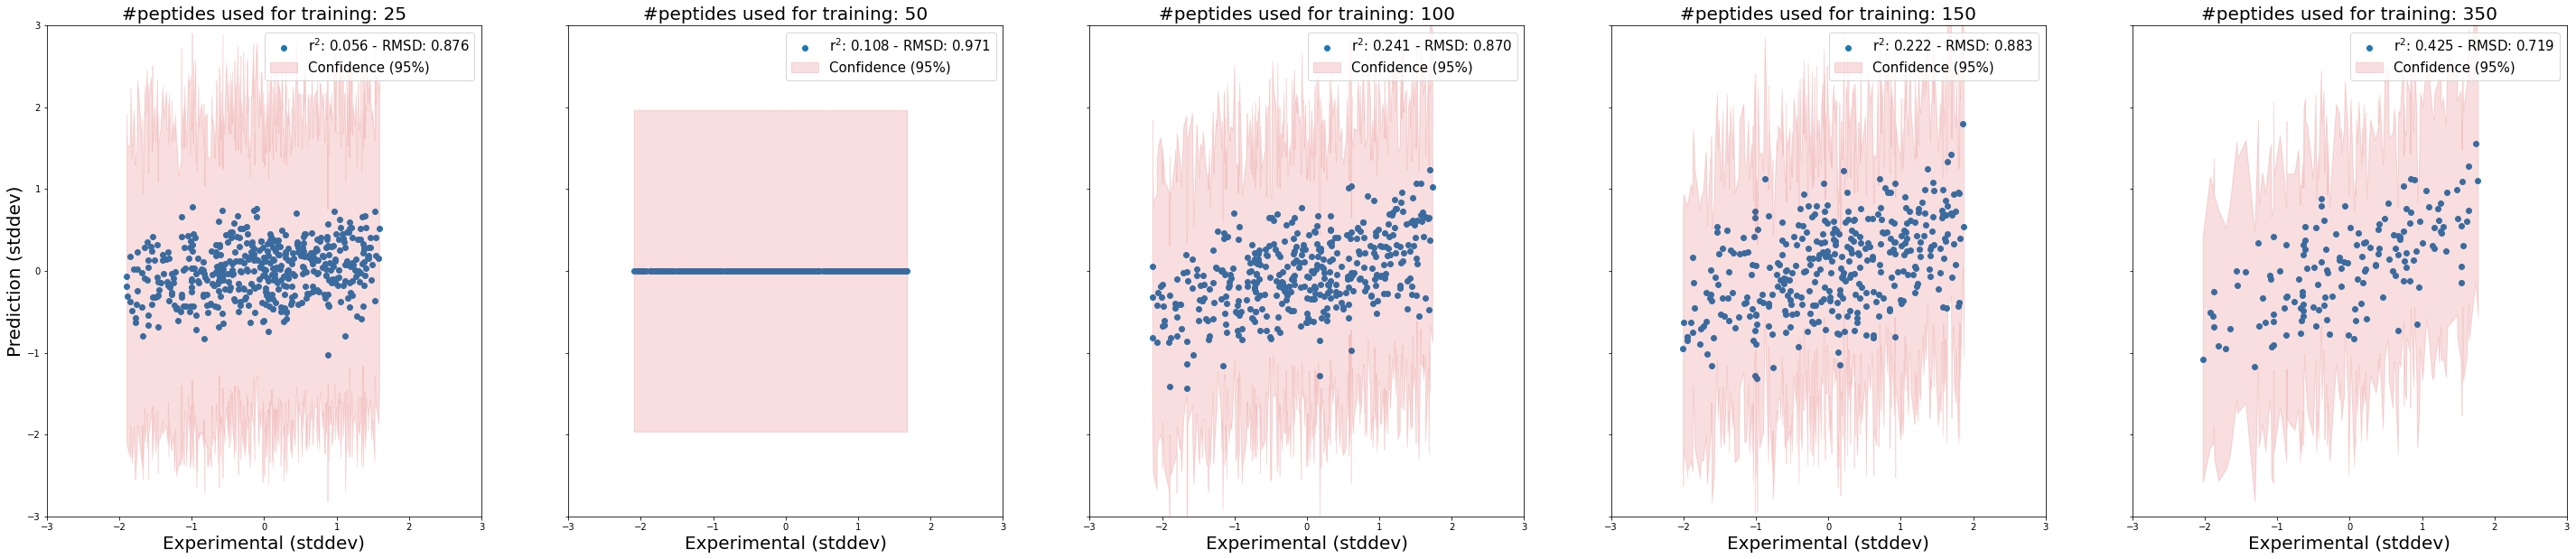

In [47]:
energy_bounds = [affinity_binding_to_energy(1, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = StandardScaler()
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=StandardScaler())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

plt.show()

### Affinity binding values between 1 uM and 1 mM (noise sigma: 1, values normalized)

Energy bounds: -8.235 / -4.118 kcal/mol


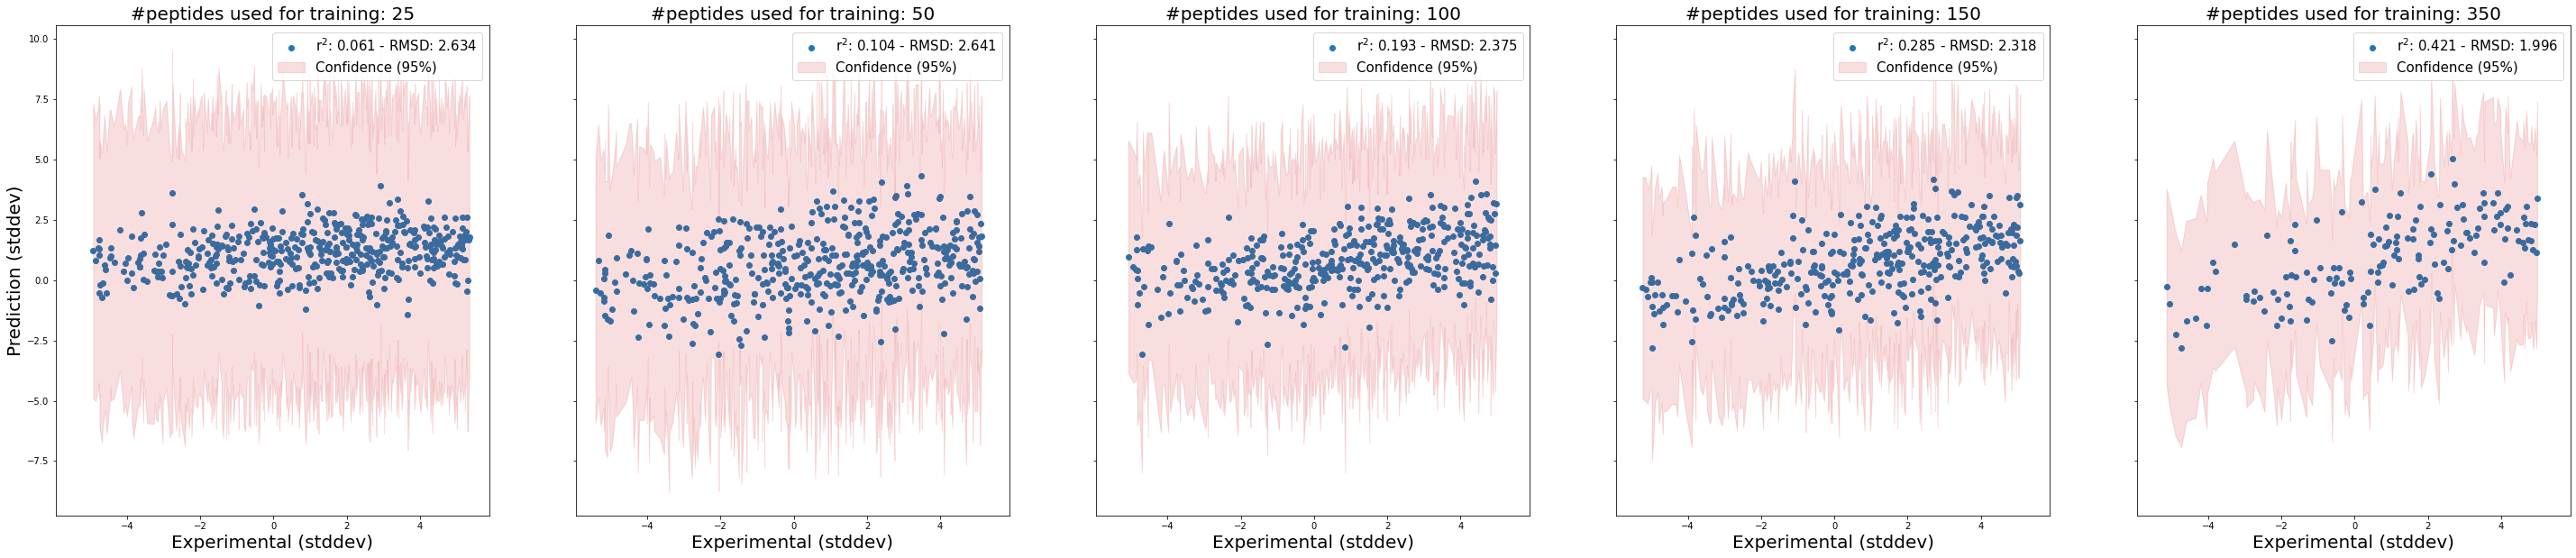

In [48]:
energy_bounds = [affinity_binding_to_energy(1, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = MinMaxScaler((-5, 5))
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=MinMaxScaler((-5, 5)))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])

plt.show()

### Affinity binding values between 1 nM and 1 uM (noise sigma: 1, values standardized)

Energy bounds: -12.353 / -8.235 kcal/mol


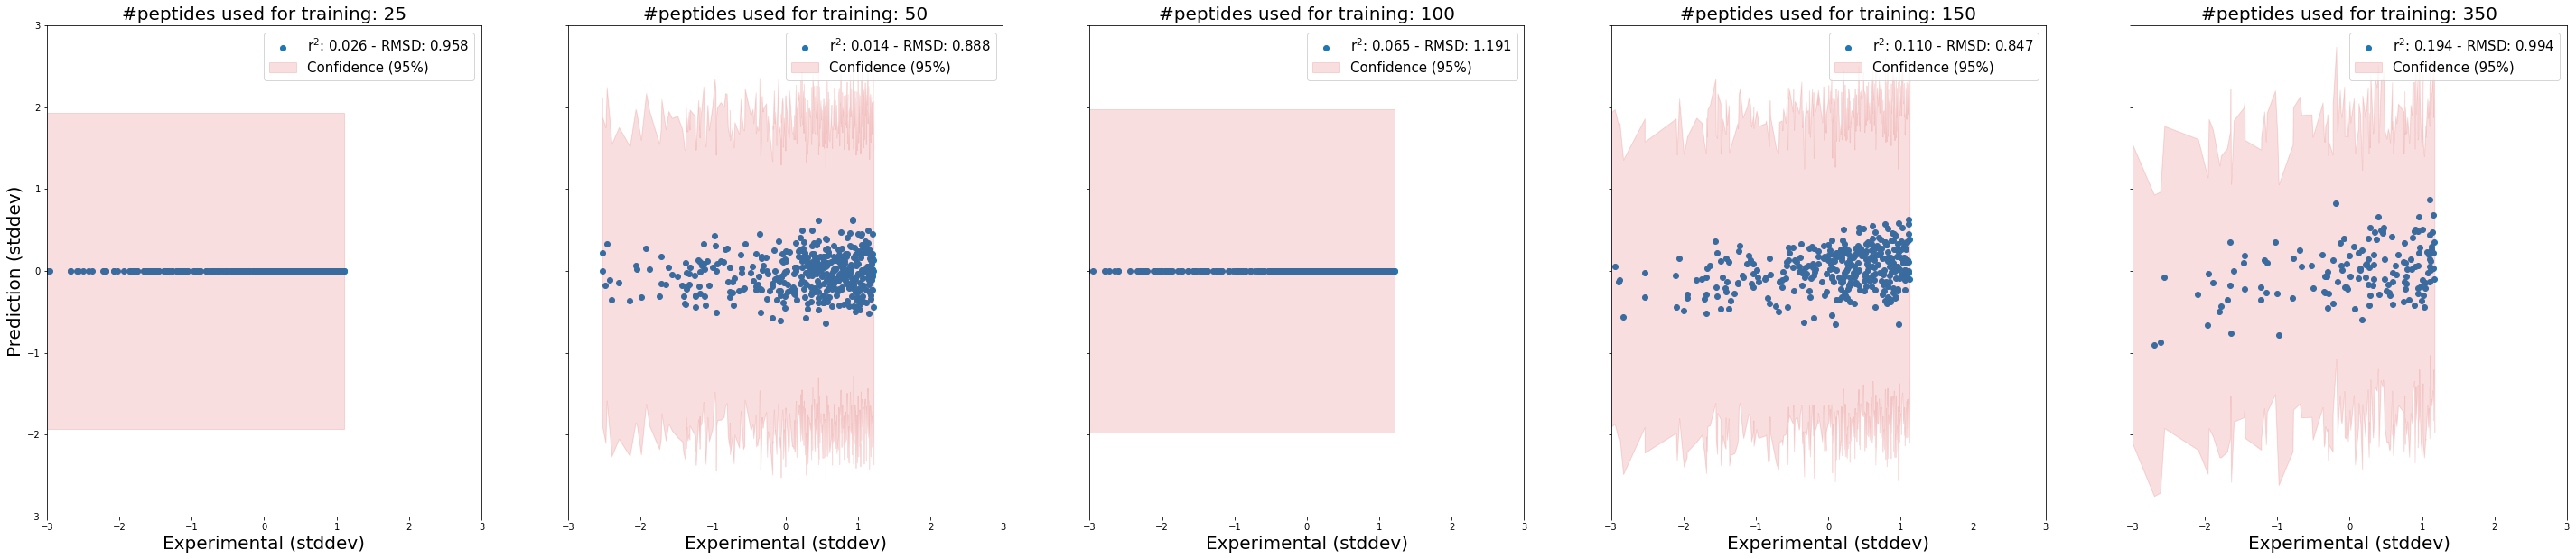

In [49]:
energy_bounds = [affinity_binding_to_energy(1, 'nM'), affinity_binding_to_energy(1, 'uM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = StandardScaler()
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=StandardScaler())
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

plt.show()

### Affinity binding values between 1 nM and 1 uM (noise sigma: 1, values normalized)

Energy bounds: -12.353 / -8.235 kcal/mol


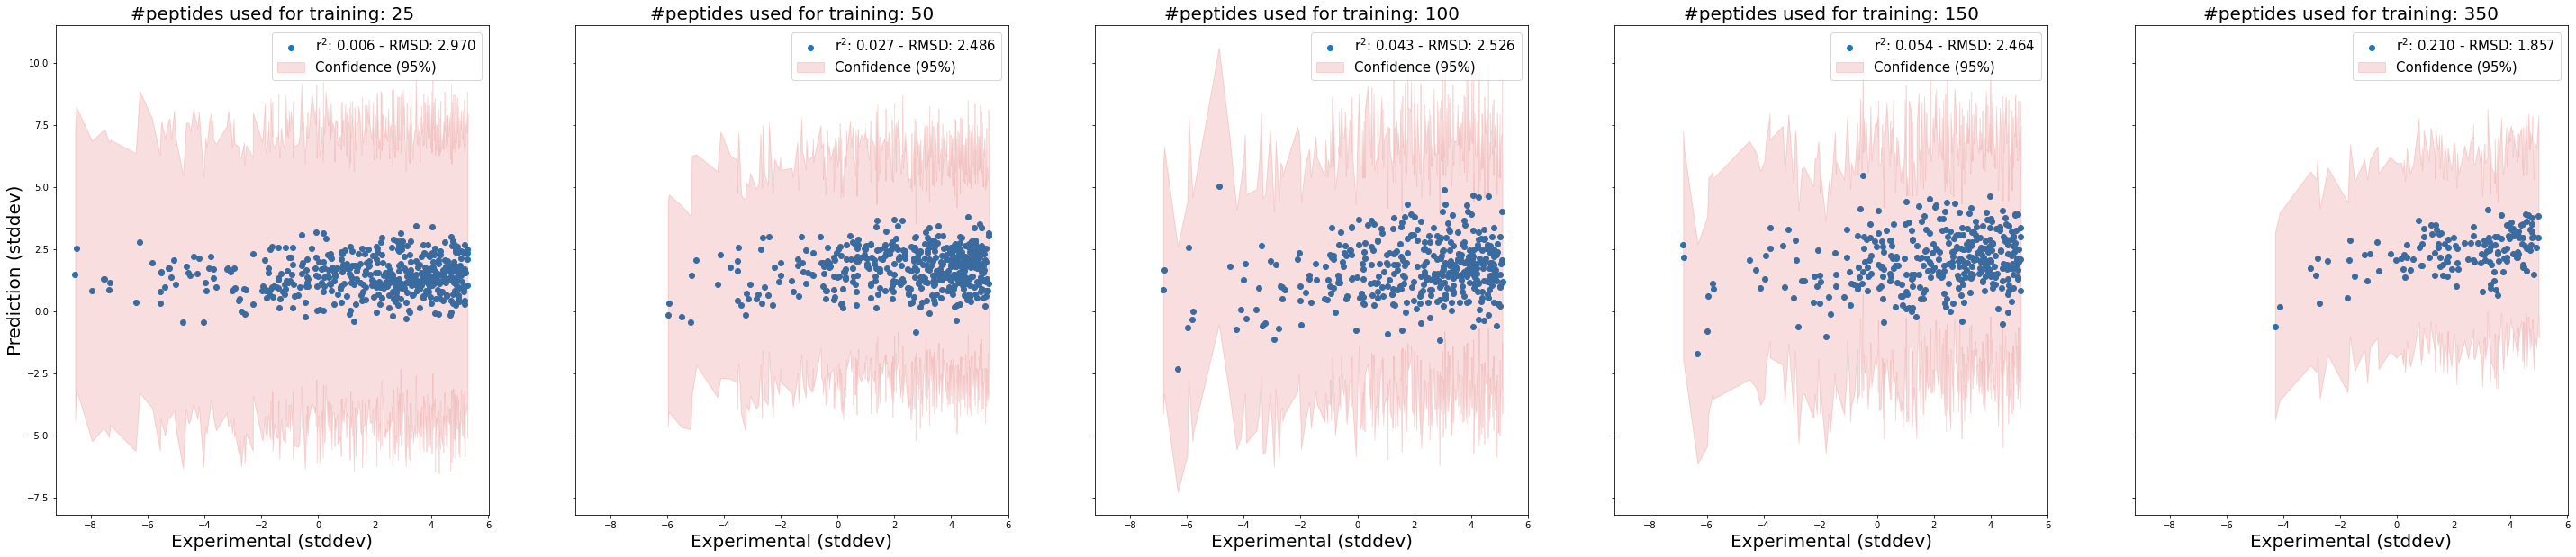

In [50]:
energy_bounds = [affinity_binding_to_energy(1, 'nM'), affinity_binding_to_energy(1, 'uM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
map4_fps = map4.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = MinMaxScaler((-5, 5))
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=MinMaxScaler((-5, 5)))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])

plt.show()

### Affinity binding values between 500 uM and 1 mM (noise sigma: 1, values normalized, PCA)

Energy bounds: -4.531 / -4.118 kcal/mol


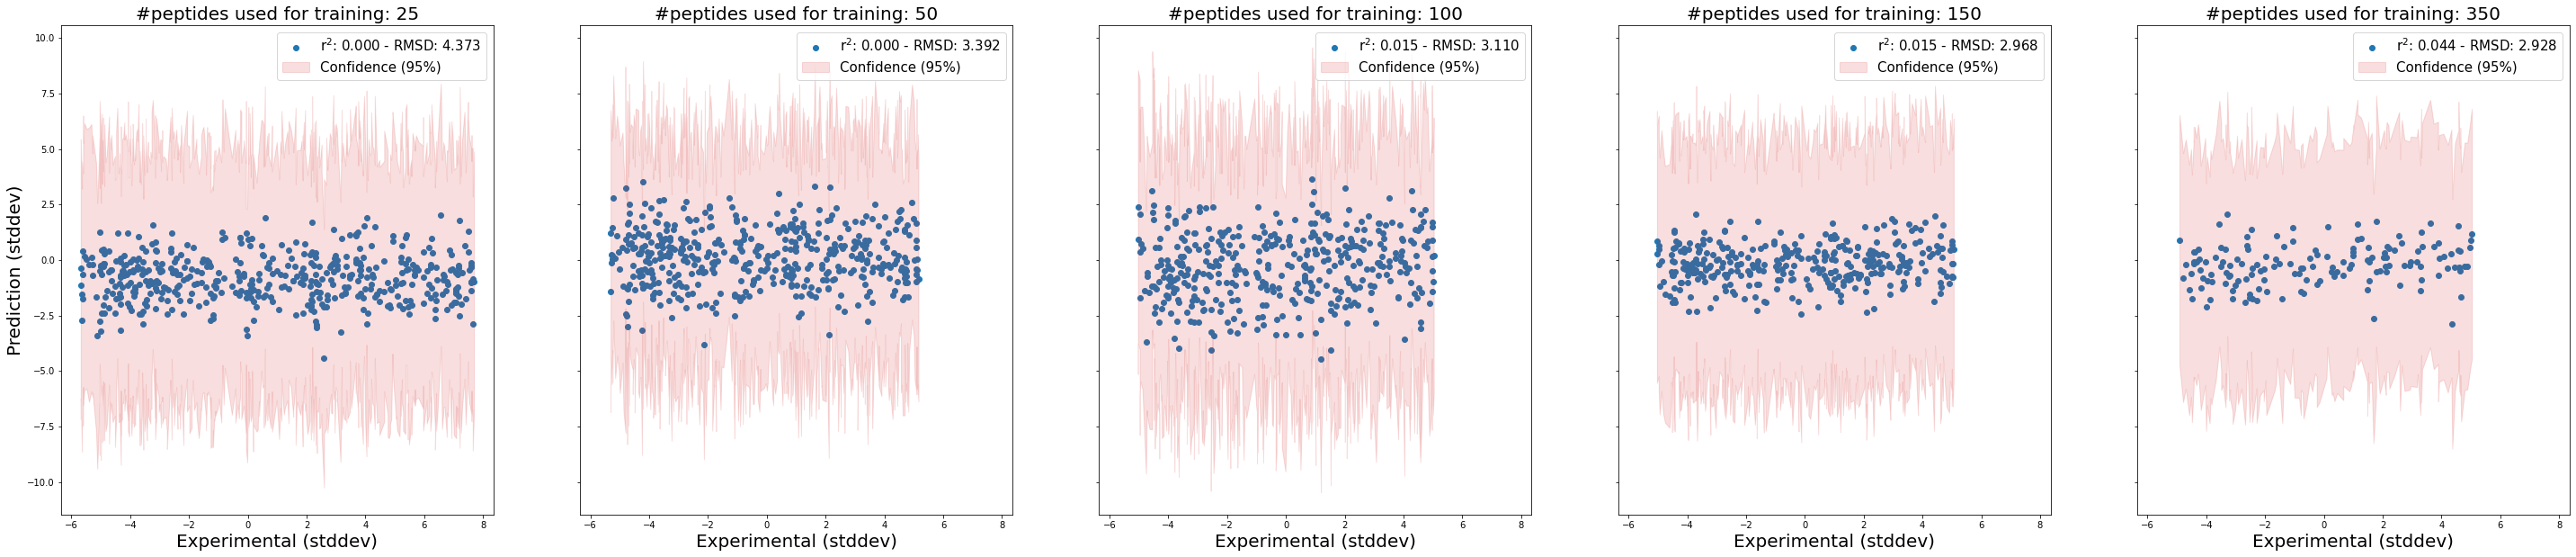

In [51]:
energy_bounds = [affinity_binding_to_energy(500, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
seq_trans = SequenceDescriptors(pd.read_csv('pca.csv'))
map4_fps = seq_trans.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = MinMaxScaler((-5, 5))
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=MinMaxScaler((-5, 5)))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])

plt.show()

### Affinity binding values between 1 uM and 1 mM (noise sigma: 1, values normalized, PCA)

Energy bounds: -8.235 / -4.118 kcal/mol


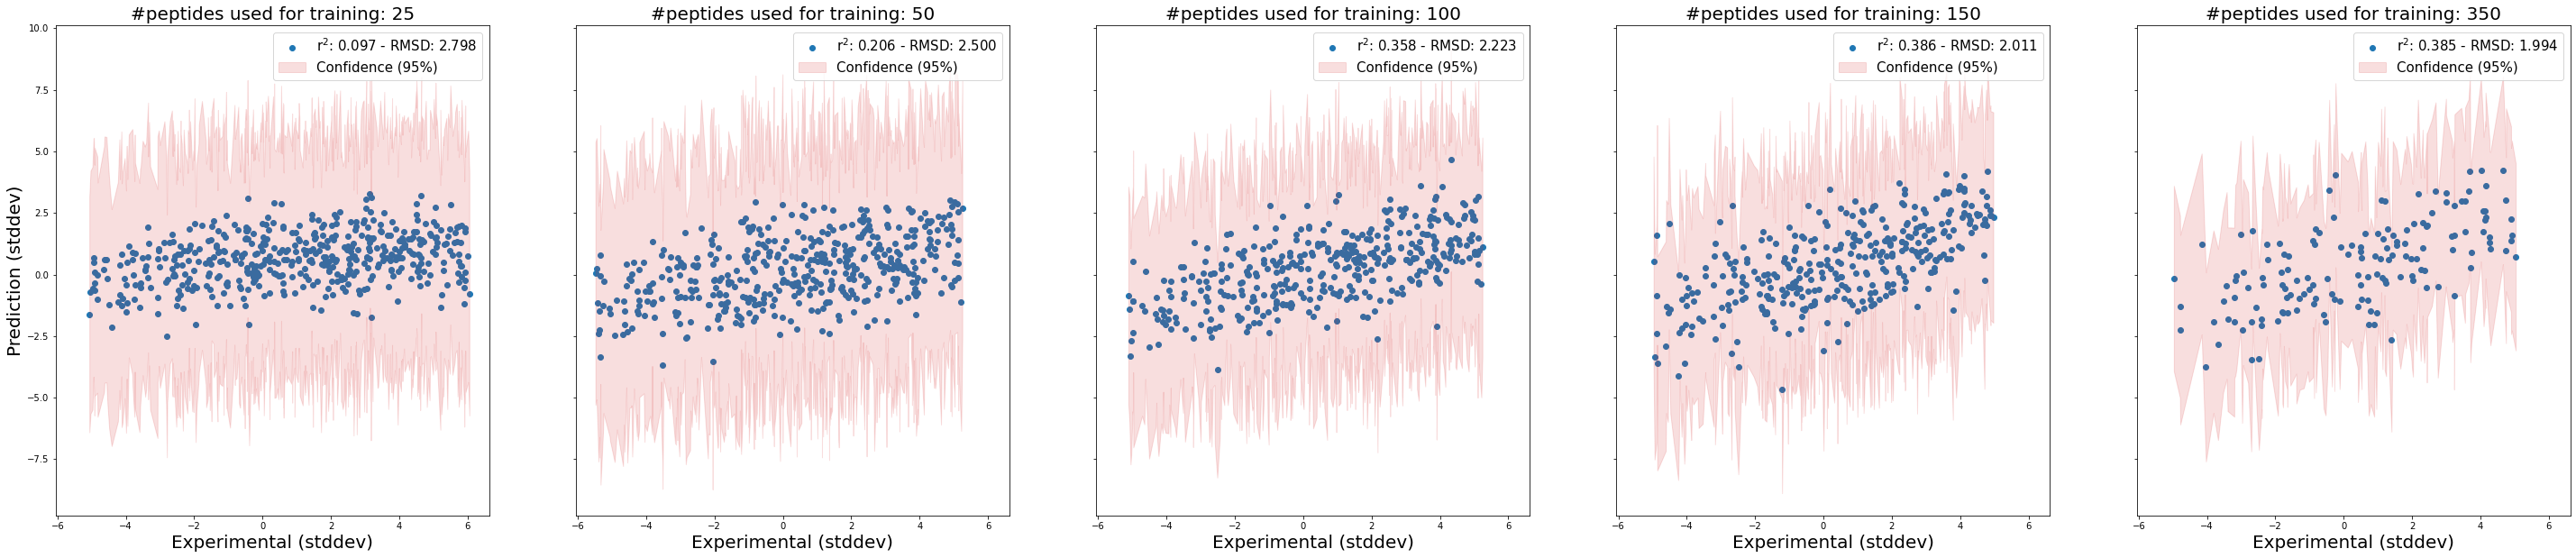

In [52]:
energy_bounds = [affinity_binding_to_energy(1, 'uM'), affinity_binding_to_energy(1, 'mM')]
test_sizes = [0.95, 0.9, 0.8, 0.7, 0.3]

print('Energy bounds: %.3f / %.3f kcal/mol' % (energy_bounds[0], energy_bounds[1]))

# Generate random peptides
random_peptides, random_peptide_scores = mps.generate_random_peptides(500, 9, energy_bounds)
seq_trans = SequenceDescriptors(pd.read_csv('pca.csv'))
map4_fps = seq_trans.transform(random_peptides)

fig, axarr = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(50, 10))

for i, ax in enumerate(axarr.ravel()):
    # Split data in train/test sets
    X_train, X_test, y_train, y_test = train_test_split(map4_fps, random_peptide_scores, test_size=test_sizes[i])
    
    # Scaling
    scaler = MinMaxScaler((-5, 5))
    scaler.fit(y_train[:,None])
    y_train_scaled = scaler.transform(y_train[:,None]).flatten()
    y_test_scaled = scaler.transform(y_test[:,None]).flatten()
    
    # Fit GP model and do prediction with scaling
    gp = GPModel(kernel=TanimotoSimilarityKernel(), scaler=MinMaxScaler((-5, 5)))
    gp.fit(X_train, y_train)
    predictions = gp.transform(X_test)
    y_pred_scaled = predictions.mean.detach().numpy()
    confidence = predictions.confidence_region()
    lower = confidence[0].detach().numpy()
    upper = confidence[1].detach().numpy()
    idx = np.argsort(y_test_scaled)
    
    # Plotting
    ax.scatter(y_test_scaled, y_pred_scaled, label=r'r$^2$: %.3f - RMSD: %.3f' % (pearsonr(y_test_scaled, y_pred_scaled)[0]**2, rmsd(y_test_scaled, y_pred_scaled)))
    ax.fill_between(y_test_scaled[idx], lower[idx], upper[idx], color='tab:red', alpha=0.15, label='Confidence (95%)')
    ax.set_title('#peptides used for training: %d' % y_train_scaled.shape[0], fontsize=20)
    ax.set_xlabel('Experimental (stddev)', fontsize=20)
    ax.legend(loc='upper right', fontsize=15)

axarr[0].set_ylabel('Prediction (stddev)', fontsize=20)
#ax.set_xlim([-5, 5])
#ax.set_ylim([-5, 5])

plt.show()

## MAP4 fingerprint testing

In [310]:
map4 = Map4Fingerprint(input_type='smiles', dimensions=2048)
map4_fps = map4.transform(['C(CC[N+])CC(C(=O)O)N', 'C(C(C(=O)[O-])N)C(=O)O', 'C(CCN)CC(C(=O)O)N', 'C(C(C(=O)O)N)C(=O)O'])

tensor(0.0680) tensor(1.) tensor(0.3713)


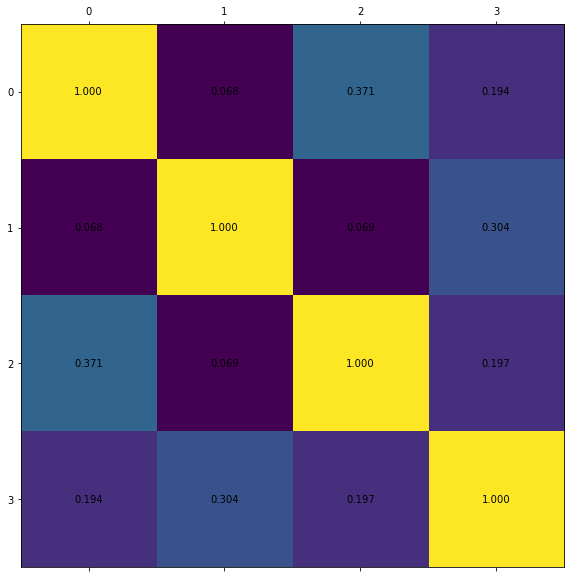

In [382]:
map4 = Map4Fingerprint(input_type='smiles', dimensions=4096)
map4_fps = map4.transform(['C(CC[N+])CC(C(=O)O)N', 'C(C(C(=O)[O-])N)C(=O)O', 'C(CCN)CC(C(=O)O)N', 'C(C(C(=O)O)N)C(=O)O'])

t = TanimotoSimilarityKernel()
m = t.forward(torch.from_numpy(map4_fps).float(), torch.from_numpy(map4_fps).float())

print(m.min(), m.max(), m.std())

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(m)
for (i, j), z in np.ndenumerate(m):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.show()

tensor(0.1268) tensor(1.) tensor(0.3427)


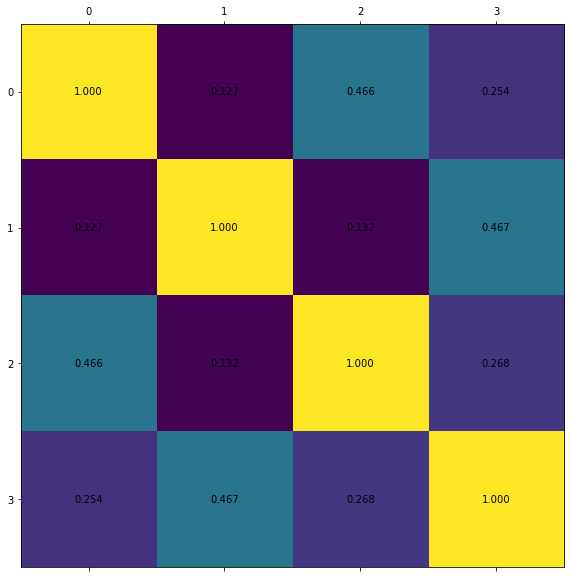

In [381]:
map4 = Map4Fingerprint(input_type='smiles', dimensions=2048, radius=1)
map4_fps = map4.transform(['C(CC[N+])CC(C(=O)O)N', 'C(C(C(=O)[O-])N)C(=O)O', 'C(CCN)CC(C(=O)O)N', 'C(C(C(=O)O)N)C(=O)O'])

t = TanimotoSimilarityKernel()
m = t.forward(torch.from_numpy(map4_fps).float(), torch.from_numpy(map4_fps).float())

print(m.min(), m.max(), m.std())

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(m)
for (i, j), z in np.ndenumerate(m):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.show()

tensor(0.0489) tensor(1.) tensor(0.2892)


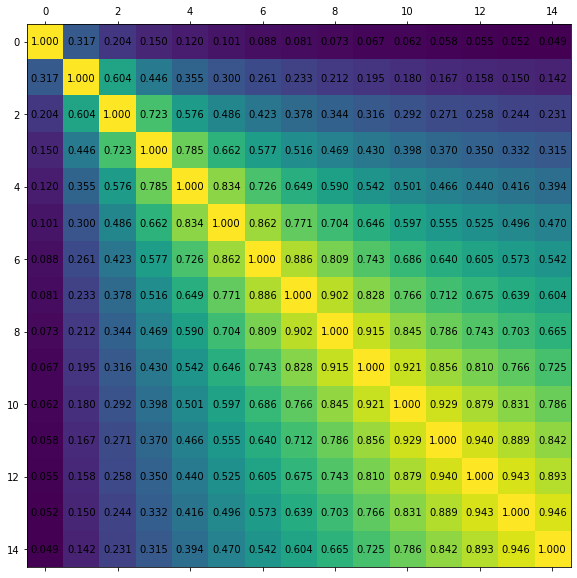

In [385]:
map4 = Map4Fingerprint(input_type='fasta', dimensions=2048, radius=1)
map4_fps = map4.transform(['K' * i for i in range(1, 16)])

t = TanimotoSimilarityKernel()
m = t.forward(torch.from_numpy(map4_fps).float(), torch.from_numpy(map4_fps).float())

print(m.min(), m.max(), m.std())

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(m)
for (i, j), z in np.ndenumerate(m):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.show()

tensor(0.0453) tensor(1.) tensor(0.2913)


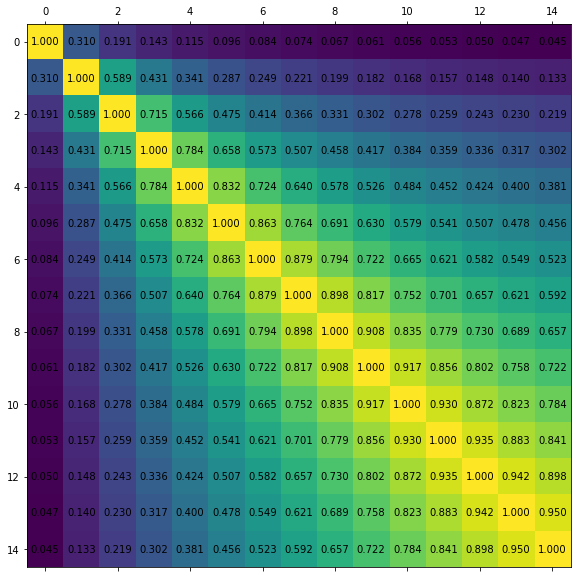

In [386]:
map4 = Map4Fingerprint(input_type='fasta', dimensions=8192, radius=2)
map4_fps = map4.transform(['W' * i for i in range(1, 16)])

t = TanimotoSimilarityKernel()
m = t.forward(torch.from_numpy(map4_fps).float(), torch.from_numpy(map4_fps).float())

print(m.min(), m.max(), m.std())

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(m)
for (i, j), z in np.ndenumerate(m):
    ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center')
plt.show()